In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from statsmodels.tsa.arima_model import ARIMA


import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import plotly.express as px
import numpy as np 
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
def plot_model_performance(y_pred, y_test):

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    columns = ['Accuracy', 'Precision', 'Recall', 'F1 score']
    data = [accuracy, precision, recall, f1]
    df_metrics = pd.DataFrame(data=data, index=columns, columns=['metrics'])

    # Plot metrics
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Bar plot for metrics
    axes[0].bar(df_metrics.index, df_metrics['metrics'], color='grey')
    axes[0].set_xlabel('Metrics', fontsize=14)
    axes[0].set_ylabel('Scores', fontsize=14)
    axes[0].set_title('Model Performance Metrics', fontsize=20, fontweight='bold')
    axes[0].set_ylim(0, 1)
    for bar in axes[0].patches:
        height = bar.get_height()
        axes[0].annotate(f'{height:.2f}', 
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

    # Confusion matrix
    dt_cf = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(dt_cf).plot(ax=axes[1], cmap='coolwarm')
    axes[1].set_title('Confusion Matrix', fontsize=20, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

In [4]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
apple_stock = yf.download('AAPL') 
apple_stock.drop(columns=['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)
apple_stock.index = pd.to_datetime(apple_stock.index)
apple_stock = apple_stock[apple_stock.index > '2010-01-01']
apple_stock

[*********************100%%**********************]  1 of 1 completed


,Adj Close,Volume
Date,,
2010-01-04,6.470742,493729600
2010-01-05,6.481928,601904800
2010-01-06,6.378826,552160000
2010-01-07,6.367033,477131200
2010-01-08,6.409362,447610800
...,...,...
2024-06-13,214.240005,97862700
2024-06-14,212.490005,70122700
2024-06-17,216.669998,93728300


In [6]:
apple_stock.index = pd.to_datetime(apple_stock.index)
apple_stock

,Adj Close,Volume
Date,,
2010-01-04,6.470742,493729600
2010-01-05,6.481928,601904800
2010-01-06,6.378826,552160000
2010-01-07,6.367033,477131200
2010-01-08,6.409362,447610800
...,...,...
2024-06-13,214.240005,97862700
2024-06-14,212.490005,70122700
2024-06-17,216.669998,93728300


In [7]:
apple_stock['1-Day Return'] = apple_stock['Adj Close'].pct_change(1) * 100
apple_stock['5-Day Return'] = apple_stock['Adj Close'].pct_change(5) * 100
apple_stock['1-Month Return'] = apple_stock['Adj Close'].pct_change(21) * 100
apple_stock['1-Day volume change'] = apple_stock['Volume'].pct_change(1) * 100

apple_stock = apple_stock.dropna()

C:\Users\12436\AppData\Local\Temp\ipykernel_27480\3141059678.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_stock['1-Day Return'] = apple_stock['Adj Close'].pct_change(1) * 100
C:\Users\12436\AppData\Local\Temp\ipykernel_27480\3141059678.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_stock['5-Day Return'] = apple_stock['Adj Close'].pct_change(5) * 100
C:\Users\12436\AppData\Local\Temp\ipykernel_27480\3141059678.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Text(0.5, 1.0, '1-Day Volume')

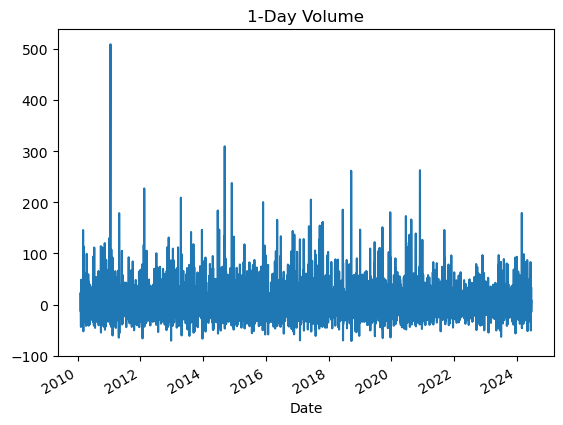

In [8]:
apple_stock['1-Day volume change'].plot()
plt.title('1-Day Volume')

In [9]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(apple_stock['1-Day volume change'])

# Extract and print the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -30.004460403201886
p-value: 0.0


 As we can see above, after the adfuller hypothesis test, the p_value is smaller that 0.05, which means that we have enough evidence to reject the null hypothesis and agree that the series is stationary. We plot the return data in the figrue below.

In [10]:
train = apple_stock[apple_stock.index <= '2024-01-01']
test = apple_stock[apple_stock.index > '2024-01-01']
print(f'Train set size: {train.shape}')
print(f'Test set size: {test.shape}')

Train set size: (3501, 6)
Test set size: (118, 6)


In [11]:
model1 = SARIMAX(train['1-Day Return'], order=(1, 0, 0), exog= train['1-Day volume change'])
model1_fit = model1.fit()
print(model1_fit.summary())

c:\Users\12436\.conda\envs\Capstones\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\12436\.conda\envs\Capstones\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           1-Day Return   No. Observations:                 3501
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -6964.250
Date:                Fri, 21 Jun 2024   AIC                          13934.501
Time:                        05:11:15   BIC                          13952.983
Sample:                             0   HQIC                         13941.097
                               - 3501                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
1-Day volume change    -0.0041      0.001     -7.413      0.000      -0.005      -0.003
ar.L1                  -0.0424      0.011     -3.735      0.000      -0.065      -0.020
sigma2          

In [12]:
history = train['1-Day Return'].tolist() 
exog_history = train['1-Day volume change'].tolist()
predictions = []


for t in range(len(test)):

    model = SARIMAX(history, order=(1, 0, 0), exog=exog_history)
    model_fit = model.fit(disp=False)  # disp=False to suppress output

    output = model_fit.forecast(steps=1, exog=[test['1-Day volume change'][t]])
    yhat = output[0]
    predictions.append(yhat)

    obs = test['1-Day Return'][t]
    obs_exo = test['1-Day volume change'][t]
    history.append(obs)
    exog_history.append(obs_exo)

    print(f'Finished {t+1} round(s), {len(test)-t-1} left')

Finished 1 round(s), 117 left
Finished 2 round(s), 116 left
Finished 3 round(s), 115 left
Finished 4 round(s), 114 left
Finished 5 round(s), 113 left
Finished 6 round(s), 112 left
Finished 7 round(s), 111 left
Finished 8 round(s), 110 left
Finished 9 round(s), 109 left
Finished 10 round(s), 108 left
Finished 11 round(s), 107 left


c:\Users\12436\.conda\envs\Capstones\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Finished 12 round(s), 106 left
Finished 13 round(s), 105 left
Finished 14 round(s), 104 left
Finished 15 round(s), 103 left
Finished 16 round(s), 102 left
Finished 17 round(s), 101 left
Finished 18 round(s), 100 left
Finished 19 round(s), 99 left
Finished 20 round(s), 98 left
Finished 21 round(s), 97 left
Finished 22 round(s), 96 left
Finished 23 round(s), 95 left
Finished 24 round(s), 94 left
Finished 25 round(s), 93 left
Finished 26 round(s), 92 left
Finished 27 round(s), 91 left
Finished 28 round(s), 90 left
Finished 29 round(s), 89 left
Finished 30 round(s), 88 left
Finished 31 round(s), 87 left
Finished 32 round(s), 86 left
Finished 33 round(s), 85 left
Finished 34 round(s), 84 left
Finished 35 round(s), 83 left
Finished 36 round(s), 82 left
Finished 37 round(s), 81 left


c:\Users\12436\.conda\envs\Capstones\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Finished 38 round(s), 80 left
Finished 39 round(s), 79 left
Finished 40 round(s), 78 left
Finished 41 round(s), 77 left
Finished 42 round(s), 76 left
Finished 43 round(s), 75 left
Finished 44 round(s), 74 left
Finished 45 round(s), 73 left
Finished 46 round(s), 72 left
Finished 47 round(s), 71 left
Finished 48 round(s), 70 left
Finished 49 round(s), 69 left
Finished 50 round(s), 68 left
Finished 51 round(s), 67 left
Finished 52 round(s), 66 left
Finished 53 round(s), 65 left
Finished 54 round(s), 64 left
Finished 55 round(s), 63 left
Finished 56 round(s), 62 left
Finished 57 round(s), 61 left
Finished 58 round(s), 60 left
Finished 59 round(s), 59 left
Finished 60 round(s), 58 left
Finished 61 round(s), 57 left
Finished 62 round(s), 56 left
Finished 63 round(s), 55 left
Finished 64 round(s), 54 left


c:\Users\12436\.conda\envs\Capstones\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Finished 65 round(s), 53 left
Finished 66 round(s), 52 left
Finished 67 round(s), 51 left
Finished 68 round(s), 50 left
Finished 69 round(s), 49 left
Finished 70 round(s), 48 left
Finished 71 round(s), 47 left
Finished 72 round(s), 46 left
Finished 73 round(s), 45 left
Finished 74 round(s), 44 left
Finished 75 round(s), 43 left
Finished 76 round(s), 42 left
Finished 77 round(s), 41 left


c:\Users\12436\.conda\envs\Capstones\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Finished 78 round(s), 40 left
Finished 79 round(s), 39 left
Finished 80 round(s), 38 left
Finished 81 round(s), 37 left
Finished 82 round(s), 36 left
Finished 83 round(s), 35 left
Finished 84 round(s), 34 left
Finished 85 round(s), 33 left
Finished 86 round(s), 32 left
Finished 87 round(s), 31 left
Finished 88 round(s), 30 left
Finished 89 round(s), 29 left
Finished 90 round(s), 28 left
Finished 91 round(s), 27 left
Finished 92 round(s), 26 left
Finished 93 round(s), 25 left
Finished 94 round(s), 24 left
Finished 95 round(s), 23 left
Finished 96 round(s), 22 left
Finished 97 round(s), 21 left
Finished 98 round(s), 20 left
Finished 99 round(s), 19 left
Finished 100 round(s), 18 left
Finished 101 round(s), 17 left
Finished 102 round(s), 16 left
Finished 103 round(s), 15 left
Finished 104 round(s), 14 left
Finished 105 round(s), 13 left


c:\Users\12436\.conda\envs\Capstones\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Finished 106 round(s), 12 left
Finished 107 round(s), 11 left
Finished 108 round(s), 10 left
Finished 109 round(s), 9 left
Finished 110 round(s), 8 left
Finished 111 round(s), 7 left
Finished 112 round(s), 6 left
Finished 113 round(s), 5 left
Finished 114 round(s), 4 left
Finished 115 round(s), 3 left
Finished 116 round(s), 2 left
Finished 117 round(s), 1 left
Finished 118 round(s), 0 left


<Axes: xlabel='Date'>

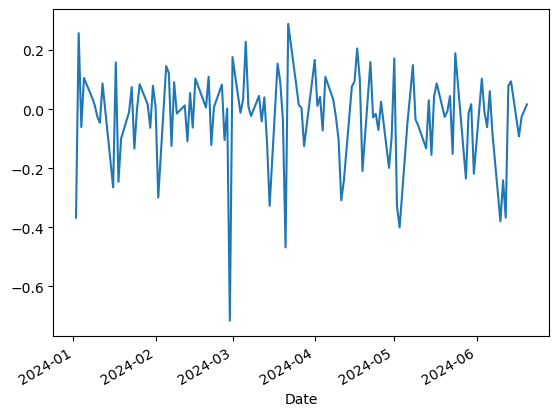

In [13]:
df1 = pd.DataFrame(data=predictions, index=test.index, columns=['predicted return difference compared with today'])
df1['predicted return difference compared with today'].plot()

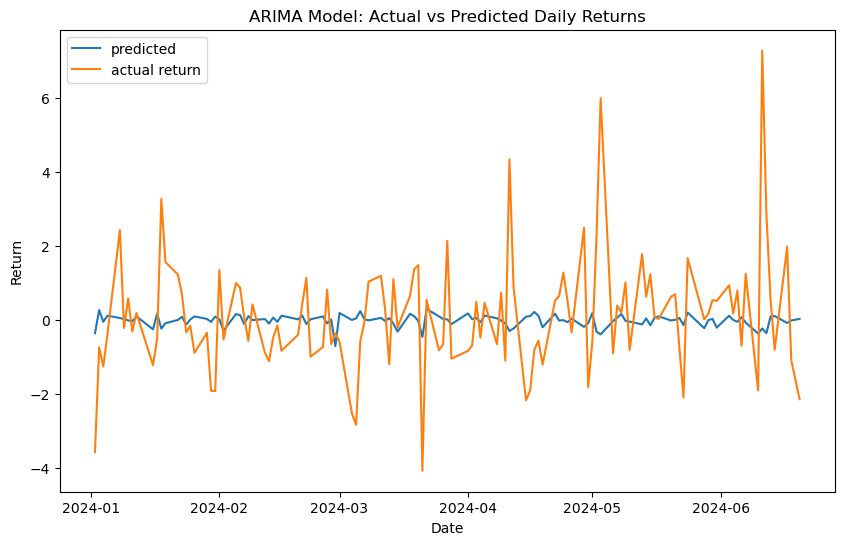

In [14]:
plt.figure(figsize = (10,6))

plt.plot(df1['predicted return difference compared with today'], label = 'predicted')
plt.plot(test['1-Day Return'], label = 'actual return')
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('ARIMA Model: Actual vs Predicted Daily Returns')
plt.legend()
plt.show()

In [15]:
test['1-Day Return binary'] = np.where(test['1-Day Return']>0, 1, 0)
test['5-Day Return binary'] = np.where(test['5-Day Return']>0, 1, 0)
test['1-Month Return binary'] = np.where(test['1-Month Return']>0, 1, 0)

C:\Users\12436\AppData\Local\Temp\ipykernel_27480\2646082025.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['1-Day Return binary'] = np.where(test['1-Day Return']>0, 1, 0)
C:\Users\12436\AppData\Local\Temp\ipykernel_27480\2646082025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['5-Day Return binary'] = np.where(test['5-Day Return']>0, 1, 0)
C:\Users\12436\AppData\Local\Temp\ipykernel_27480\2646082025.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [16]:
df1['predicted binary'] = np.where(df1['predicted return difference compared with today']>0, 1, 0)

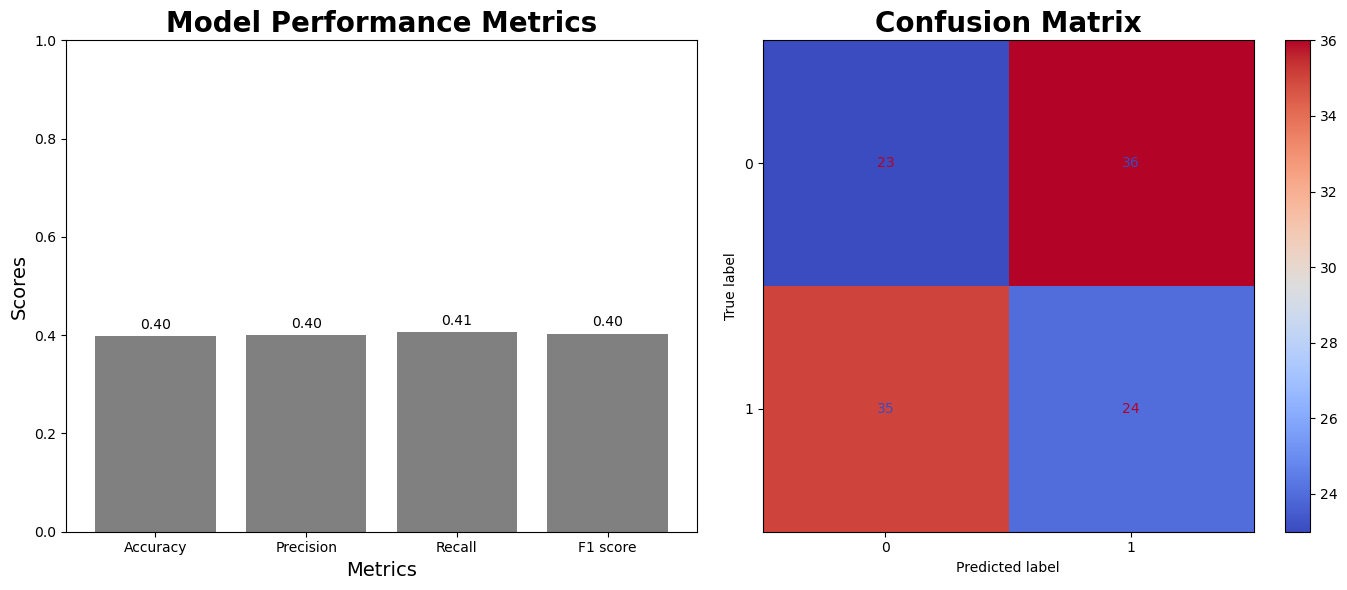

In [17]:
plot_model_performance(df1['predicted binary'], test['1-Day Return binary'])

C:\Users\12436\AppData\Local\Temp\ipykernel_18372\2719053514.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_stock['5-Day volume change'] = apple_stock['Volume'].pct_change(5)*100


<Axes: xlabel='Date'>

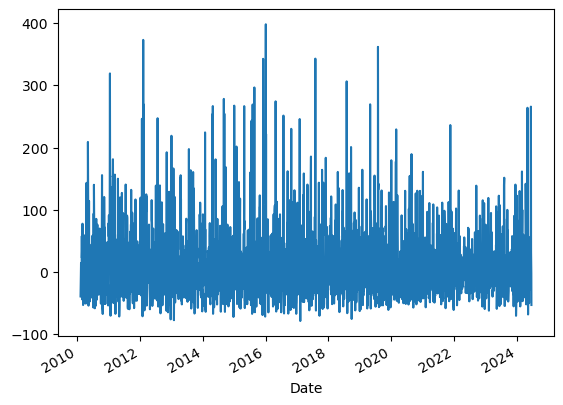

In [28]:
apple_stock['5-Day volume change'] = apple_stock['Volume'].pct_change(5)*100
apple_stock['5-Day volume change'].plot()